# Unit 3 Capstone Project
  ## Matthew Kennedy, August 2017

   ## Section 1: Overview of Dataset and Analysis of Data
   
   The dataset used in this project comes from Kaggle user "CNuge." The dataset contains historical stock prices over the last five years for all companies in the S&P 500 index and can be found at https://www.kaggle.com/camnugent/sandp500. This project will use the files that have the historical prices for individual stocks.   
       
   The dataset contains the following columns: 
       
       Date - In the format of yy-mm-dd
       Open - Price of the stock in USD at market open
       High - Highest price reached in the day
       Low - Lowest price reached in the day
       Close - The price the stock had at the end of the day
       Volume - Number of shares traded
       Name - The stock's ticker name
       
   The user collected the data by using the python library, 'pandas_datareader,' to scrape Google Finance.

In [1]:
# Import the necessary modules
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

C:\Users\maken\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# This project will use the historical prices of GOOGL

# Read the Dataset, store the original
# This is the filepath on my laptop:
#original = pd.read_csv('C:\\Users\\mkennedy\\sandp500\\individual_stocks_5yr\\GOOGL_data.csv', encoding='utf-8-sig')
# This is the filepath on my desktop:
original = pd.read_csv('D:\\Data\\sandp500\\GOOGL_data.csv')

In [3]:
# Copy a dataframe of the original data to manipulate
data = original

# Print the headers of the dataframe
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL


In [4]:
# Check the footer to make sure there are no rows of text
data.tail()

,Date,Open,High,Low,Close,Volume,Name
1253,8/7/2017,947.52,948.96,943.50,945.75,1445754,GOOGL
1254,8/8/2017,944.29,952.49,942.48,944.19,1505064,GOOGL
1255,8/9/2017,938.45,943.76,933.92,940.08,1400852,GOOGL
1256,8/10/2017,935.00,936.30,921.78,923.59,2707393,GOOGL
1257,8/11/2017,923.71,933.36,921.22,930.09,1616708,GOOGL


There are no footers that need to be excluded.
There are 1257 rows of stock data. 

In [5]:
# The describe method provides some additional information about the data
data.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,616.760469,621.377719,611.501638,616.599809,2.076615e+06
std,170.726853,171.626054,169.458607,170.631830,1.081167e+06
min,323.320000,326.830000,318.320000,323.910000,5.211410e+05
25%,510.217500,514.237500,504.365000,508.212500,1.453572e+06
50%,579.000000,583.625000,573.405000,579.170000,1.820138e+06
75%,758.737500,765.280000,754.065000,759.822500,2.343574e+06
max,1005.490000,1008.610000,996.620000,1004.280000,1.285814e+07


In [6]:
# The dtypes call will display the data types. 
# This is used to make sure all numerical values have the correct data type to work with in the models.
print(data.dtypes)

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object


The dataset appears to be clean and easy to work with.

Observe the correlations between columns by using seaborn's heatmap.

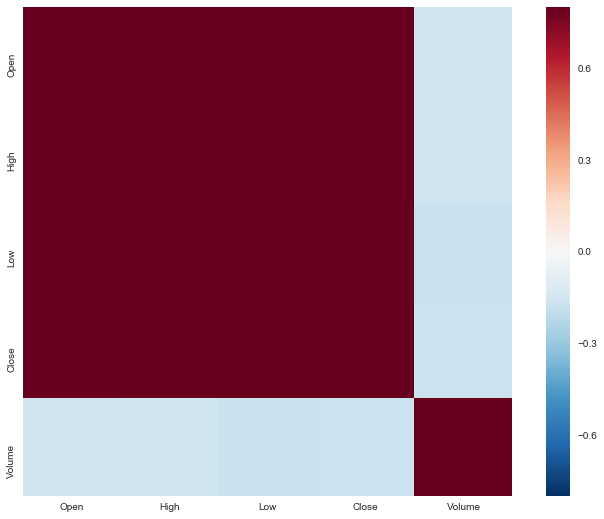

In [7]:
# Create a heatmap to compare the correlation of the columns.
import seaborn as sns

corrmat = data.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

As expected, the values are highly correlated. Creating prediction models based off of time-series data will not be helpful in reaching the goal of this project (to determine whether to buy or sell the at the next opening day). 

Features will need to be created to generate accurate predictions from the models. 

In [8]:
# The momentum will show how many days in a row the stock has moved up or down. 

# Create a list to store the momentum
momentum = [0]
i=1
# Calculate the momentums and store them in the new column, 'Momentum'
for row in data['Close']:
    if i < len(data):
        if data.Close[i] > data.Close[i-1]:
            momentum.append(+1)
            i = i+1
        elif data.Close[i] < data.Close[i-1]:
            momentum.append(-1)
            i = i+1

data['Momentum'] = momentum
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1


In [9]:
# Print out the total momentum and the average momentum across all rows.
total_mom = sum(data.Momentum)
print(total_mom)
ave_mom = data.Momentum.mean()
print(ave_mom)

61
0.04848966613672496


In [10]:
streak = [0] * len(data)
i=1
# Calculate the streaks and store them in the new column, 'Streak'
for row in data['Close']:
    if i < len(data):
        if data.Close[i] > data.Close[i-1]:
            if streak[i-1] >= 0:
                streak[i] = streak[i-1]+1
                i = i+1
            else:
                streak[i]=0
                i = i+1
        elif data.Close[i] < data.Close[i-1]:
            if streak[i-1] <= 0:
                streak[i] = streak[i-1]-1
                i = i+1
            else:
                streak[i]=0
                i = i+1

data['Streak'] = streak
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0,0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1,1
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1,0
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1,1
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1,2


In [11]:
# Create a 'Future Momentum' feature that the model will attempt to predict.
data['Future Momentum'] = data.Momentum.shift(-1)
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0,0,1.0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1,1,-1.0
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1,0,1.0
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1,1,1.0
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1,2,-1.0


In [12]:
data.tail()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum
1253,8/7/2017,947.52,948.96,943.50,945.75,1445754,GOOGL,-1,0,-1.0
1254,8/8/2017,944.29,952.49,942.48,944.19,1505064,GOOGL,-1,-1,-1.0
1255,8/9/2017,938.45,943.76,933.92,940.08,1400852,GOOGL,-1,-2,-1.0
1256,8/10/2017,935.00,936.30,921.78,923.59,2707393,GOOGL,-1,-3,1.0
1257,8/11/2017,923.71,933.36,921.22,930.09,1616708,GOOGL,1,0,NaN


In [13]:
# Drop the last row to get rid of the NaN values
data = data.iloc[:len(data)-1,:]

In [14]:
# Look at the tail to make sure the data looks good
data.tail()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum
1252,8/4/2017,943.95,947.54,939.80,945.79,1254574,GOOGL,1,1,-1.0
1253,8/7/2017,947.52,948.96,943.50,945.75,1445754,GOOGL,-1,0,-1.0
1254,8/8/2017,944.29,952.49,942.48,944.19,1505064,GOOGL,-1,-1,-1.0
1255,8/9/2017,938.45,943.76,933.92,940.08,1400852,GOOGL,-1,-2,-1.0
1256,8/10/2017,935.00,936.30,921.78,923.59,2707393,GOOGL,-1,-3,1.0


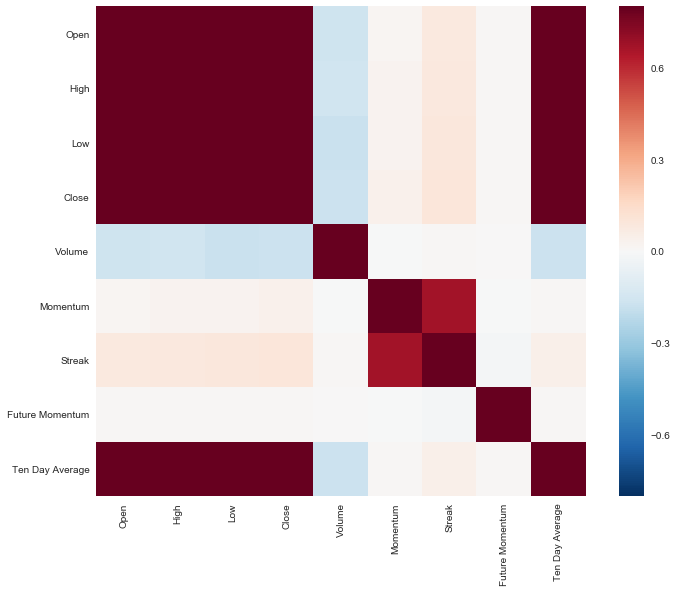

In [17]:
# Create a heatmap with the new features.

corrmat = new_data.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

# Section 2: Creation and Comparison of Predictive Models

Now that the data has been analyzed to ensure it can be manipulated, it is time to create some predictive models. For comparison, the scores from the models will be stored in a new table, titled "Model Comparison."

In [18]:
# Create a table to store the scores for each model.
# Title: Model Comparison
# Columns: Model, R^2, Accuracy, AUROC
# Model values: Linear Regression, Ridge Regression, Lasso Regression, Support Vector Regression, Gradient Boost Classification
models = {'Model':[], 'Scoring Metric':[], 'Scoring Value':[]}
columns = models.keys()
model_comparison = pd.DataFrame(data=models, columns=columns)
model_comparison

,Model,Scoring Metric,Scoring Value


In [58]:
# Set the variables. 
# Use the closing value for Y
# Use the new features for X
Y = data['Future Momentum']
X = data[['Close', 'Volume', 'Momentum', 'Streak']]

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 90% of the data in the training set.
X_train, Y_train = X[:offset], Y[:offset]

# And put 10% in the test set.
X_test, Y_test = X[offset:], Y[offset:]

# Logistic Regression

In [59]:
# Declare a logistic regression classifier.
# Larger C's lead to reduced regularization of parameters, but because there are
#   few features, the value of C has a trivial effect (tested for many C's)
lr = LogisticRegression(C=1e9)

# Fit the model.
lr.fit(X_train,Y_train)
y_pred = lr.fit(X_train,Y_train).predict(X_test)


print('Confusion Matrix of the Model:')
conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

# Use Accuracy for Logistic Regression Scoring Metric
cv = cross_val_score(lr, X, Y, cv=10, scoring='accuracy') 
print('Accuracy Score:')
print(cv)
# Print the average of the R2 and store it in the table
print('Average of the Accuracy Score:')
print(cv.mean())

# Store the data in the model_comparison table
models = {'Model':['Logistic Regression'], 'Scoring Metric':'Accuracy', 'Scoring Value':[cv.mean()]}
model_comparison = model_comparison.append(pd.DataFrame(data=models, columns=models.keys()), ignore_index=True)

Confusion Matrix of the Model:
[[  0 117]
 [  0 135]]
Accuracy Score:
[ 0.52380952  0.52380952  0.52380952  0.52380952  0.52380952  0.52380952
  0.52380952  0.52380952  0.528       0.52419355]
Average of the Accuracy Score:
0.524266973886


In [60]:
print(y_pred)
print(y_pred.mean())

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

# Ridge Regression

In [96]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)

y_pred = ridgeregr.fit(X_train,Y_train).predict(X_test)

# Print the R2.
cv = cross_val_score(ridgeregr, X, Y, cv=10, scoring='r2') 
print('R2 Score:')
print(cv)
# Print the average of the R2 and store it in the table
print('Average of the R2 Score:')
print(cv.mean())

# Store the data in the model_comparison table
models = {'Model':['Ridge Regression'], 'Scoring Metric':'R2', 'Scoring Value':[cv.mean()]}
model_comparison = model_comparison.append(pd.DataFrame(data=models, columns=models.keys()), ignore_index=True)

R2 Score:
[ -1.76650557e-03  -8.22193653e-03   9.58609575e-04  -3.54075289e-03
  -8.63520489e-05  -3.15263337e-04  -1.85405358e-03  -1.19014702e-03
  -5.36217513e-03  -5.70910153e-02]
Average of the R2 Score:
-0.00784695917995


In [97]:
print(y_pred)
print(y_pred.mean())

[ -6.11610631e-03   3.45111633e-02   8.37872952e-02   1.35004433e-01
   6.62328123e-02   3.38155344e-02   8.76897298e-02   1.30740222e-01
   1.80670674e-01   2.36850091e-01   2.83746358e-01   6.99301741e-02
   1.15069255e-02  -8.60988998e-03   3.79933194e-02   7.10470293e-02
   2.33898569e-02  -1.18423211e-02  -8.94430193e-03   4.02851857e-02
   1.03484941e-01   8.26981284e-02   5.32546929e-02   7.12566929e-02
   2.79542572e-02   1.13714133e-02   3.96495922e-02   6.58607893e-02
   2.34709688e-02  -1.65520896e-02  -3.38924521e-03   4.63920667e-02
   7.25057801e-02   4.63941366e-02   9.24559047e-02   7.85221218e-02
   4.67170328e-02   7.02017875e-02   4.10222495e-02   6.69166251e-02
   3.99851361e-02   7.51974828e-02   5.15926585e-02   6.30033364e-02
   4.42545297e-02   6.71763892e-02   1.74369739e-02  -5.54167030e-03
  -7.04423497e-02  -3.71022945e-03   2.91407588e-02  -2.28629109e-02
   6.62414775e-03   5.31992150e-02   1.26168825e-01   1.34414804e-01
   6.23822970e-02   1.13299449e-01

# Lasso Regression

In [99]:
lasso = linear_model.Lasso(alpha=.35)
lasso.fit(X_train, Y_train)

y_pred = lasso.fit(X_train,Y_train).predict(X_test)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(Y_test, y_pred)
print(score)

# Print the R2.
cv = cross_val_score(lasso, X, Y, cv=10, scoring='r2') 
print('R2 Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the R2 Score:')
print(cv.mean())

# Store the data in the model_comparison table
models = {'Model':['Lasso Regression'], 'Scoring Metric':'R2', 'Scoring Value':[cv.mean()]}
model_comparison = model_comparison.append(pd.DataFrame(data=models, columns=models.keys()), ignore_index=True)

R-Squared of the model:
-0.00506509809597
R2 Score:
[ -3.63098054e-03  -6.03070649e-03  -1.25221729e-05  -5.38314891e-03
  -2.24001692e-03  -2.23524985e-03  -7.03649947e-04  -1.52310077e-03
  -2.92184541e-03  -1.81842409e-02]
Average of the R2 Score:
-0.00428654619254


In [100]:
print(y_pred)
print(y_pred.mean())

[ 0.01819434  0.01190747  0.01248952  0.01477884  0.01474742  0.01154773
  0.01587317  0.01158112  0.01265028  0.01880232  0.01754783  0.01823242
  0.01031514  0.01694348  0.01544584  0.01920144  0.01970914  0.02983377
  0.01595673  0.01668389  0.02892383  0.02812542  0.02762186  0.0194102
  0.02313997  0.03254737  0.01651319  0.01470491  0.01940745  0.02573599
  0.02005754  0.0215444   0.0194931   0.02121356  0.01952579  0.02457242
  0.02190444  0.01801882  0.01734174  0.01539571  0.01654107  0.02147733
  0.02536582  0.01189664  0.01978194  0.01553389  0.01453216  0.0342353
  0.02103702  0.01950323  0.02305828  0.019834    0.0274035   0.02608003
  0.04565101  0.06828425  0.03392349  0.03595877  0.03654285  0.03390032
  0.03057777  0.03011849  0.02605247  0.04816834  0.09539446  0.05762205
  0.0599214   0.04681831  0.0277888   0.02319329  0.02807601  0.02484454
  0.02094433  0.01984418  0.00829238  0.04034154  0.02353018  0.03585553
  0.04597953  0.0270895   0.02605049  0.02688088  0.0

# Support Vector Regression

In [101]:
# TODO: Look up the epsilon value for SVR
# Changing value for epsilon may reduce the overfitting

# Make a model using SVR here
svr = SVR(epsilon=.5)
svr.fit(X_train,Y_train)
y_pred = svr.fit(X_train,Y_train).predict(X_test)

# Use Accuracy for the Scoring Metric
cv = cross_val_score(svr, X, Y, cv=10, scoring='r2') 
print('R2 Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the R2 Score:')
print(cv.mean())

# Store the data in the model_comparison table
models = {'Model':['Support Vector Regression'], 'Scoring Metric':'R2', 'Scoring Value':[cv.mean()]}
model_comparison = model_comparison.append(pd.DataFrame(data=models, columns=models.keys()), ignore_index=True)

R2 Score:
[ -3.24882390e-03  -1.91231150e-03  -5.44323850e-04  -1.91231150e-03
  -1.04272341e-04  -3.24882390e-03  -1.61141748e-03  -2.41664551e-03
  -2.62064570e-06  -1.38435358e-02]
Average of the R2 Score:
-0.00288450863917


In [102]:
print(y_pred)
print(y_pred.mean())

[ 0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303  0.02139303
  0.02139303  0.02139303  0.02139303  0.02139303  0

# Support Vector Classifier

In [109]:
# Change the parameters C, gamma, and Kernal type to see if the model can be improved.
# Write definitions of the parameters here.

# Make a model using SVR here
svc = SVC(C=.1)
svc.fit(X_train,Y_train)
y_pred = svc.fit(X_train,Y_train).predict(X_test)

print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

# Print the Accuracy.
cv = cross_val_score(svc, X, Y, cv=10, scoring='accuracy') 
print('Accuracy Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the Accuracy Score:')
print(cv.mean())


# Store the data in the model_comparison table
models = {'Model':['Support Vector Classifier'], 'Scoring Metric':'Accuracy', 'Scoring Value':[cv.mean()]}
model_comparison = model_comparison.append(pd.DataFrame(data=models, columns=models.keys()), ignore_index=True)

Confusion Matrix of the model:
[[  0 117]
 [  0 135]]
Accuracy Score:
[ 0.52380952  0.52380952  0.52380952  0.52380952  0.52380952  0.52380952
  0.52380952  0.52380952  0.528       0.52419355]
Average of the Accuracy Score:
0.524266973886


In [104]:
print(y_pred)
print(y_pred.mean())

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

# Gradient Boosting Classifier

In [110]:
# 500 iterations, using 5-deep trees, and loss function 'deviance.'
# Play around with number of iterations
# Look into learning rate

### Document results of different numbers of n_estimators and max_depth. 

params = {'n_estimators': 500,
          'max_depth': 5,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train,Y_train)
y_pred = clf.fit(X_train,Y_train).predict(X_test)

print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

# Print the AUROC.
cv = cross_val_score(clf, X, Y, cv=10, scoring='accuracy') 
print('Accuracy Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the Accuracy Score:')
print(cv.mean())

# Store the data in the model_comparison table
models = {'Model':['Gradient Boosting Classifier'], 'Scoring Metric':'Accuracy', 'Scoring Value':[cv.mean()]}
model_comparison = model_comparison.append(pd.DataFrame(data=models, columns=models.keys()), ignore_index=True)

Confusion Matrix of the model:
[[68 49]
 [77 58]]
Accuracy Score:
[ 0.54761905  0.4047619   0.53174603  0.50793651  0.52380952  0.41269841
  0.5         0.54761905  0.44        0.53225806]
Average of the Accuracy Score:
0.494844854071


In [106]:
print(y_pred)
print(y_pred.mean())

[-1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1.
 -1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
 -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.
  1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1.
  1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1.
  1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.
 -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.
 -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1. -1

# Section 3: Selection and Analysis of the Best Performing Model

Display the model comparison table here. Write up an analysis. 

In [107]:
model_comparison

,Model,Scoring Metric,Scoring Value
0,Logistic Regression,Accuracy,0.524267
1,Ridge Regression,R2,-0.007847
2,Lasso Regression,R2,-0.004287
3,Support Vector Regression,R2,-0.002885
4,Support Vector Classifier,Accuracy,0.524267
5,Gradient Boosting Classifier,Accuracy,0.502781
6,Logistic Regression,Accuracy,0.524267
7,Logistic Regression,Accuracy,0.524267
8,Support Vector Classifier,Accuracy,0.524267
9,Support Vector Classifier,Accuracy,0.524267


Analysis of table goes here. 

# Being provided one thousand dollars cash every ten business days, how will the top three models perform compared to one another as well as to a 401(k) approach?

In [33]:
# Create a cash_available list that stores how much cash is available 
# to buy the stocks. It will be $1000 every ten business days.
cash_available = [1000]

# Create a list for stocks and cash

# Start out with 0 stocks_owned
stocks_owned = [0]

In [34]:
# Create a pred_return function to calculate the returns of the prediction models
def pred_return(y_pred, data, cash_available, stocks_owned):
    # Create DataFrame for values
    new_values = {'Stocks':[],'Cash':[]}
    columns = new_values.keys()
    values = pd.DataFrame(data=new_values, columns=columns)
    for i in range(len(y_pred)):
        # For every tenth iteration of i, add 1000 to cash_available
        if i%10 == 0:
            cash_available = cash_available+1000
        # If the predicted value is greater than zero, buy more stock
        if y_pred[i] > 0:
            [stocks_owned,cash_available] = buy_stock(cash_available, 
                                                      stocks_owned, y_pred, 
                                                      data.Close[i])
        # If the predicted value is less than zero, sell stock
        elif y_pred[i] < 0:
            [stocks_owned,cash_available] = sell_stock(cash_available, 
                                                      stocks_owned, y_pred, 
                                                      data.Close[i])
        stocks_owned = [stocks_owned,cash_available][0]
        cash_available = [stocks_owned,cash_available][1]
        new_values = {'Stocks':[stocks_owned], 'Cash':[cash_available]}
        values = values.append(pd.DataFrame(data=new_values, columns=
                                            new_values.keys()), 
                                            ignore_index=True)
    print(values,y_pred)
    return(values)

In [35]:
# Create a buy_stock function that buys as many stocks as can be afforded
def buy_stock(cash_available, stocks_owned, y_pred, value):
    # Set number of stocks to buy
    num_stocks_buy = int(cash_available/value)
    # Subtract from cash_available, store it in a list
    cash_available = cash_available-num_stocks_buy*value
    stocks_owned = stocks_owned+num_stocks_buy
    return(stocks_owned, cash_available)

In [36]:
# Create a sell_stock function that sells all stocks
def sell_stock(cash_available, stocks_owned, y_pred, value):
    sell_value = stocks_owned*value
    cash_available = cash_available + sell_value
    stocks_owned = 0
    return(stocks_owned, cash_available)

In [81]:
# Create the 401k approach simulator, safe_invest, 
# That buys as much stock as is available every two weeks / ten business days.
def safe_invest(data, cash_available, stocks_owned):
    # Create DataFrame for values
    new_values = {'Stocks':[],'Cash':[]}
    columns = new_values.keys()
    values = pd.DataFrame(data=new_values, columns=columns)
    for i in range(len(data.loc[offset:,:])):
        # For every tenth iteration of i, add 1000 to cash_available
        if i%10 == 0:
            cash_available = cash_available+1000
        num_stocks_buy = int(cash_available/data.Close[i])
        stocks_owned = num_stocks_buy + stocks_owned
        cash_available = cash_available-num_stocks_buy*data.Close[i]
        # Store the values in a table
        new_values = {'Stocks':[stocks_owned], 'Cash':[cash_available]}
        values = values.append(pd.DataFrame(data=new_values, columns=
                                            new_values.keys()), 
                                            ignore_index=True)

    print(values)
    return(values)

In [61]:
# Run the pred_return function for lr
y_pred = lr.fit(X_train,Y_train).predict(X_test)
cash_available = 0
stocks_owned = 0
values = pred_return(y_pred, data, cash_available, stocks_owned)

     Stocks    Cash
0       3.0    8.98
1       3.0    8.98
2       3.0    8.98
3       3.0    8.98
4       3.0    8.98
5       3.0    8.98
6       3.0    8.98
7       3.0    8.98
8       3.0    8.98
9       3.0    8.98
10      6.0    4.16
11      6.0    4.16
12      6.0    4.16
13      6.0    4.16
14      6.0    4.16
15      6.0    4.16
16      6.0    4.16
17      6.0    4.16
18      6.0    4.16
19      6.0    4.16
20      8.0  311.28
21      8.0  311.28
22      8.0  311.28
23      8.0  311.28
24      8.0  311.28
25      8.0  311.28
26      8.0  311.28
27      8.0  311.28
28      8.0  311.28
29      8.0  311.28
..      ...     ...
222    60.0  270.05
223    60.0  270.05
224    60.0  270.05
225    60.0  270.05
226    60.0  270.05
227    60.0  270.05
228    60.0  270.05
229    60.0  270.05
230    62.0  349.53
231    62.0  349.53
232    62.0  349.53
233    62.0  349.53
234    62.0  349.53
235    62.0  349.53
236    62.0  349.53
237    62.0  349.53
238    62.0  349.53
239    62.0  349.53


In [62]:
# Calculate the ending returns from the lr model
lr_returns = values.loc[len(values)-1,'Stocks']*data.loc[len(y_pred)-1,'Close'] + values.loc[len(values)-1, 'Cash']
print(lr_returns)

29297.44


In [63]:
# 252 trading days in a year, 2017-2012 is 6 years, 
# $1000 granted every 10 days = 151,200 dollars granted.
# Since we are predicting the last 20% of the data, divide by 20
# Get total profit by subrtracting returns by dollars granted. 
lr_profit = lr_returns - 7560
print(lr_profit)

21737.44


In [64]:
# Run the pred_return function for svr
y_pred = svr.fit(X_train,Y_train).predict(X_test)
cash_available = 0
stocks_owned = 0
values = pred_return(y_pred, data, cash_available, stocks_owned)

     Stocks    Cash
0       3.0    8.98
1       3.0    8.98
2       3.0    8.98
3       3.0    8.98
4       3.0    8.98
5       3.0    8.98
6       3.0    8.98
7       3.0    8.98
8       3.0    8.98
9       3.0    8.98
10      6.0    4.16
11      6.0    4.16
12      6.0    4.16
13      6.0    4.16
14      6.0    4.16
15      6.0    4.16
16      6.0    4.16
17      6.0    4.16
18      6.0    4.16
19      6.0    4.16
20      8.0  311.28
21      8.0  311.28
22      8.0  311.28
23      8.0  311.28
24      8.0  311.28
25      8.0  311.28
26      8.0  311.28
27      8.0  311.28
28      8.0  311.28
29      8.0  311.28
..      ...     ...
222    60.0  270.05
223    60.0  270.05
224    60.0  270.05
225    60.0  270.05
226    60.0  270.05
227    60.0  270.05
228    60.0  270.05
229    60.0  270.05
230    62.0  349.53
231    62.0  349.53
232    62.0  349.53
233    62.0  349.53
234    62.0  349.53
235    62.0  349.53
236    62.0  349.53
237    62.0  349.53
238    62.0  349.53
239    62.0  349.53


In [68]:
#values.to_csv('D:\\GitHub\\Thinkful_Unit_3\\svr_values.csv')

In [65]:
# Calculate the ending returns from the svr model
svr_returns = values.loc[len(values)-1,'Stocks']*data.loc[len(y_pred)-1,'Close'] + values.loc[len(values)-1, 'Cash']
print(svr_returns)

29297.44


In [67]:
# 252 trading days in a year, 2017-2012 is 6 years, 
# $1000 granted every 10 days = 151,200 dollars granted.
# Get total profit by subrtracting returns by dollars granted. 
svr_profit = svr_returns - 7560
print(svr_profit)

21737.44


In [93]:
# Run the pred_return function for svc
y_pred = svc.fit(X_train,Y_train).predict(X_test)
cash_available = 0
stocks_owned = 0
values = pred_return(y_pred, data, cash_available, stocks_owned)

     Stocks    Cash
0       3.0    8.98
1       3.0    8.98
2       3.0    8.98
3       3.0    8.98
4       3.0    8.98
5       3.0    8.98
6       3.0    8.98
7       3.0    8.98
8       3.0    8.98
9       3.0    8.98
10      6.0    4.16
11      6.0    4.16
12      6.0    4.16
13      6.0    4.16
14      6.0    4.16
15      6.0    4.16
16      6.0    4.16
17      6.0    4.16
18      6.0    4.16
19      6.0    4.16
20      8.0  311.28
21      8.0  311.28
22      8.0  311.28
23      8.0  311.28
24      8.0  311.28
25      8.0  311.28
26      8.0  311.28
27      8.0  311.28
28      8.0  311.28
29      8.0  311.28
..      ...     ...
222    60.0  270.05
223    60.0  270.05
224    60.0  270.05
225    60.0  270.05
226    60.0  270.05
227    60.0  270.05
228    60.0  270.05
229    60.0  270.05
230    62.0  349.53
231    62.0  349.53
232    62.0  349.53
233    62.0  349.53
234    62.0  349.53
235    62.0  349.53
236    62.0  349.53
237    62.0  349.53
238    62.0  349.53
239    62.0  349.53


In [94]:
# Calculate the ending returns from the svc model
svc_returns = values.loc[len(values)-1,'Stocks']*data.loc[len(y_pred)-1,'Close'] + values.loc[len(values)-1, 'Cash']
print(svc_returns)

29297.44


In [95]:
# 252 trading days in a year, 2017-2012 is 6 years, 
# $1000 granted every 10 days = 151,200 dollars granted.
# Get total profit by subrtracting returns by dollars granted. 
svc_profit = svc_returns - 7560
print(svc_profit)

21737.44


In [72]:
# Run the pred_return function for gradient boosting classifier
y_pred = clf.fit(X_train,Y_train).predict(X_test)
cash_available = 0
stocks_owned = 0
values = pred_return(y_pred, data, cash_available, stocks_owned)

     Stocks      Cash
0       0.0   1000.00
1       0.0   1000.00
2       2.0    331.80
3       2.0    331.80
4       0.0   1009.62
5       2.0    333.40
6       2.0    333.40
7       2.0    333.40
8       2.0    333.40
9       2.0    333.40
10      5.0    328.58
11      5.0    328.58
12      0.0   2050.33
13      6.0      3.25
14      6.0      3.25
15      6.0      3.25
16      6.0      3.25
17      0.0   2103.55
18      5.0    336.40
19      5.0    336.40
20      0.0   3068.60
21      0.0   3068.60
22      0.0   3068.60
23      8.0    227.08
24      8.0    227.08
25      0.0   3103.08
26      8.0    190.20
27      0.0   3105.56
28      8.0    166.68
29      0.0   3167.16
..      ...       ...
222     0.0  24020.63
223     0.0  24020.63
224     0.0  24020.63
225     0.0  24020.63
226     0.0  24020.63
227     0.0  24020.63
228     0.0  24020.63
229     0.0  24020.63
230    54.0    166.59
231     0.0  24992.01
232     0.0  24992.01
233     0.0  24992.01
234     0.0  24992.01
235     0.

In [73]:
# Calculate the ending returns from the clf model
clf_returns = values.loc[len(values)-1,'Stocks']*data.loc[len(y_pred)-1,'Close'] + values.loc[len(values)-1, 'Cash']
print(clf_returns)

26644.42


In [74]:
# 252 trading days in a year, 2017-2012 is 6 years, 
# $1000 granted every 10 days = 151,200 dollars granted.
# Get total profit by subrtracting returns by dollars granted. 
clf_profit = clf_returns - 7560
print(clf_profit)

19084.42


In [82]:
# Run the safe_invest function
cash_available = 0
stocks_owned = 0
values = safe_invest(data, cash_available, stocks_owned)

     Stocks    Cash
0       3.0    8.98
1       3.0    8.98
2       3.0    8.98
3       3.0    8.98
4       3.0    8.98
5       3.0    8.98
6       3.0    8.98
7       3.0    8.98
8       3.0    8.98
9       3.0    8.98
10      6.0    4.16
11      6.0    4.16
12      6.0    4.16
13      6.0    4.16
14      6.0    4.16
15      6.0    4.16
16      6.0    4.16
17      6.0    4.16
18      6.0    4.16
19      6.0    4.16
20      8.0  311.28
21      8.0  311.28
22      8.0  311.28
23      8.0  311.28
24      8.0  311.28
25      8.0  311.28
26      8.0  311.28
27      8.0  311.28
28      8.0  311.28
29      8.0  311.28
..      ...     ...
222    60.0  270.05
223    60.0  270.05
224    60.0  270.05
225    60.0  270.05
226    60.0  270.05
227    60.0  270.05
228    60.0  270.05
229    60.0  270.05
230    62.0  349.53
231    62.0  349.53
232    62.0  349.53
233    62.0  349.53
234    62.0  349.53
235    62.0  349.53
236    62.0  349.53
237    62.0  349.53
238    62.0  349.53
239    62.0  349.53


In [86]:
# Calculate the ending returns from the safe_invest function
safe_returns = values.loc[len(values)-1,'Stocks']*data.loc[len(data.loc[offset:,:])-1,'Close'] + values.loc[len(values)-1, 'Cash']
print(safe_returns)

29297.44


In [87]:
# 252 trading days in a year, 2017-2012 is 6 years, 
# $1000 granted every 10 days = 151,200 dollars granted.
# Get total profit by subrtracting returns by dollars granted. 
safe_profit = safe_returns - 7560
print(safe_profit)

21737.44
